In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [5]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")[["Id","rsem.out.S442_NT"]]
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [6]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
print(len(genes_exp_df))
genes_exp_df.head(3)


23225


,Id,rsem.out.S442_NT,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4520,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,14,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [7]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "rsem.out.S442_NT"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end",
                  "rsem.out.S442_NT":"exp",
                 }

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [8]:
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

,chrom,start,end,strand,exp,size
0,chr1,11873,14409,+,0,2536
1,chr1,14361,29370,-,32,15009
2,chr1,69090,70008,+,0,918


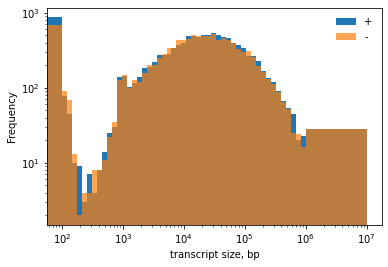

In [9]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

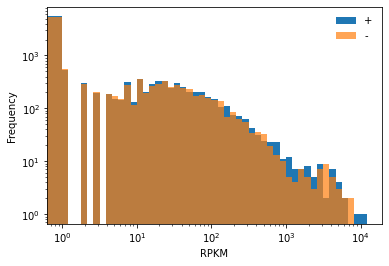

In [10]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
gdf[gdf["strand"]=="+"]["exp"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["exp"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("RPKM")
ax.legend(frameon=False)

In [11]:
exp_bin_edges = [0,.5,5,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,30_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp,size,gexp,gsize
0,chr1,11873,14409,+,0,2536,no,short
1,chr1,14361,29370,-,32,15009,high,short
2,chr1,69090,70008,+,0,918,no,short
3,chr1,134772,140566,-,0,5794,no,short
4,chr1,562759,564389,-,0,1630,no,short


gsize,short,long
gexp,,
no,7824,3006
low,1524,1240
high,4402,4298


In [12]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [13]:
def extract_ins(df,
                fname,
                bins=3000,
                flip_by_strand=False,
                flip_sign=False,
                summary = "mean",
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes (or not) ...
    """
    if flip_by_strand:
        return np.asarray([
            bbi.fetch
                   (
                        fname,
                        chrom,
                        start,
                        end,
                        bins=bins,
                        missing=0.0,
                        oob=np.nan,
                        summary=summary,
                    )[:: (-1 if strand=="-" else 1) ] * (-1 if ( (strand=="-") and (flip_sign) ) else 1 )
            # flip in place for "-" genes and multiply by -1 if requested ...
          for chrom, start, end, strand, *_ in df.itertuples(index=False)
        ])
    else:
        return np.asarray([
            bbi.fetch
                   (
                        fname,
                        chrom,
                        start,
                        end,
                        bins=bins,
                        missing=0.0,
                        oob=np.nan,
                        summary=summary,
                    )
          for chrom, start, end, *_ in df.itertuples(index=False)
        ])


### TSS to TTS scaled profiles ...

In [14]:
# key features/signals that we want to extract for our genes ...
key_features = [ 
                'ins_CTCF',
#                 'ins_noCTCF',
#                  'ins_mutCtr_CTCF',
#                  'ins_mutCtr_noCTCF',
#                  'ins_mutDDX_CTCF',
#                  'ins_mutDDX_noCTCF',
#                 "ctcf",
#                 "polII",
#                 "noctcf",
#                 'ddx_CTCF',
#                 'ddx_noCTCF',
                "Rloop_K562",
                'rad21_CTCF',
#                 'h3k27ac_r1',
#                 'h3k4_r1',
#                 'G4a_r2',
#      'dnase-hap1',
#                 'mrna_ctcf',
               ]

### Extracting Meta-gene profiles of the key-features (insulations, Chip_Seq data etc)

#### Here we extract data for + and - genes separately and flip "-" genes to orient them same way as the "+" genes ...
#### using `extract_ins` function...

In [15]:
profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                    )
                                )

extracting ins_CTCF for the genes ...
extracting Rloop_K562 for the genes ...
extracting rad21_CTCF for the genes ...


In [16]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
feat_name = "SpliceDDX"

_tmp_profiles_dict = {}
for feature_name in ['SpliceDDX55aux']:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = feature_name+".bb"
    _tmp_profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                        flip_sign=False,
                                        summary="mean"
                                    )
                                )

if key_features[-1] == feat_name:
    key_features.pop()
key_features.append(feat_name)

profiles_dict[feat_name] = {}
for key in gene_groups.groups.keys():
    profiles_dict[feat_name][key] = _tmp_profiles_dict["SpliceDDX55aux"][key]

extracting SpliceDDX55aux for the genes ...


In [17]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...

_tmp_profiles_dict = {}
for feature_name in ['CTCF_peaks_plus', 'CTCF_peaks_minus']:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = feature_name+".bb"
    _tmp_profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                        flip_sign=True,
                                        summary="mean"
                                    )
                                )

if key_features[-1] == "CTCF_peaks":
    key_features.pop()
feat_name = "CTCF_peaks"
key_features.append("CTCF_peaks")

profiles_dict["CTCF_peaks"] = {}
for key in gene_groups.groups.keys():
    profiles_dict["CTCF_peaks"][key] = _tmp_profiles_dict["CTCF_peaks_plus"][key] \
                                    - _tmp_profiles_dict["CTCF_peaks_minus"][key]

extracting CTCF_peaks_plus for the genes ...
extracting CTCF_peaks_minus for the genes ...


In [18]:
del _tmp_profiles_dict
# fill out some odf the categories with blanks - to save memory ...
for k in profiles_dict:
    profiles_dict[k][("low","short")] = np.nan
    profiles_dict[k][("low","long")] = np.nan
    profiles_dict[k][("no","short")] = np.nan
    profiles_dict[k][("high","short")] = np.nan

### introduce categories of interest here `[("high","long"), ("no","long")]` ...

In [19]:
exp_size_cats = [("high","long"), ("no","long")]

In [20]:
profiles_dict.keys()

dict_keys(['ins_CTCF', 'Rloop_K562', 'rad21_CTCF', 'SpliceDDX', 'CTCF_peaks'])

In [21]:
insulation_keys = [k for k in key_features if k.startswith("ins")]
for ins_feature in insulation_keys:
#     profiles_dict[ins_feature] = profiles_dict[ins_feature].to_dict()
    for key, ins_stack in profiles_dict[ins_feature].items():
        if key in exp_size_cats:
            l,w = ins_stack.shape
            flank_size = int(w*0.25)
            # get shoulders of the stack
            shoulder_idxs = np.r_[:flank_size,w-flank_size:w]
            profiles_dict[ins_feature][key] = ins_stack - \
                np.nanmean(
                    ins_stack[:,shoulder_idxs],
                    axis=1,
                    keepdims=True
                )


In [22]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in exp_size_cats:
    stackup_for_sorting = profiles_dict["SpliceDDX"][feature_key]
#     stackup_for_sorting = profiles_dict["CTCF_peaks"][feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = stackup_for_sorting.shape
    TSS_bin = int(width/3)
    TTS_bin = int(2*width/3)

    tmp_stack = {}
#     tmp_stack['ctcf_mean'] = np.nanmean(stackup_for_sorting[:,:TSS_bin-2],axis=1) \
#             - np.nanmean(stackup_for_sorting[:,TTS_bin-10:TTS_bin+20],axis=1)
#     tmp_stack['ctcf_mean'] = np.nanmean(stackup_for_sorting[:,TSS_bin:TTS_bin],axis=1)
    tmp_stack['splice_mean'] = np.nanmean(stackup_for_sorting[:,TSS_bin:TTS_bin],axis=1)
    
    _, _jjj = recursive_data_ordering(
        ks = [('splice_mean', "sort", 1, False)],
        idxs = np.arange( length ),
        data_dict = tmp_stack,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 4298 elements of splice_mean into 1 groups ...
sorting 3006 elements of splice_mean into 1 groups ...


In [23]:
titles = key_features

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in key_features:
    if s.startswith("CTCF_"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (-0.2,0.2)
        cmps[s] = "coolwarm"
        norms[s] = None
    elif s.startswith("Splice"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (0,0.01)
        cmps[s] = "Blues"
        norms[s] = None
    elif s.startswith("K562"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (0,0.5)
        cmps[s] = "Blues"
        norms[s] = None
    else:
        bw_fnames[s] = samples[s]["fname"]
        binsizes[s] = samples[s]["binsize"]
        flanks[s] = samples[s]["flank"]
        limss[s] = samples[s]["crange"]
        cmps[s] = samples[s]["cmap"]
        norms[s] = samples[s]["norm"]
    
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.15,.1)
    cmps[s] = cmapYlGnBu_r

limss["ctcf"] = (0,0.6)
limss["noctcf"] = (0,0.6)
limss["Rloop_K562"] = (0,5)
limss['rad21_CTCF'] = (0,.3)
limss['h3k27ac_r1'] = (0,.1)
limss['G4a_r2'] = (0,20)
limss['ddx_CTCF'] = (0,.15)
limss['ddx_noCTCF'] = (0,.15)
# limss["mrna_ctcf"] = (0,5) # use matplotlib.colors.LogNorm(vmin=1.,vmax=20.)
# limss['rad21_noCTCF'] = (0,.3)



hmss = OrderedDict()

for feature_key in exp_size_cats:
    jjj = reordered_jdxs[feature_key]
#     hmss[feature_key] = [ profiles_dict[_k][feature_key] for _k in key_features ]
    hmss[feature_key] = [ profiles_dict[_k][feature_key][jjj] for _k in key_features ]

_limss = [ limss[_k] for _k in key_features ]
_cmps = [ cmps[_k] for _k in key_features ]
_binsizes = [ binsizes[_k] for _k in key_features ]
_norms = [ norms[_k] for _k in key_features ]


In [24]:
# # plotting expression size along the new sorting order ...
# np.log(gene_groups.get_group(("high","long")).reset_index(drop=True).loc[reordered_jdxs[("high","long")]]["exp"]).plot()

#### Plotting the profiles ...

In [25]:
# def plot_sss(
#           extra_plots,
#           hmss, # will become a dictionary now (or list) ...
#           titles,
#           limss,
#           cmps,
#           norms=None,
#           binsizes=None,
#           labels=None,
#           fillmissing=False,
#           interpolation="nearest",
#           inch_per_1k_stack= 1.2, #inches per 1000 elements stackup ...
#          ):
#     # rewrite everyhting assuming hmss is a dict of stackup groups !
#     # groups are plotted on top of each other ...
        
#     if extra_plots is None:
#         extra_plots = []
    
#     # regardless - claculate number of axes for stackups ...
#     num_stackup_groups = len(hmss)
#     # pick in every stackup group and see how many are there
#     num_stackups = max(len(hmss[k]) for k in hmss)
#     num_rows = num_stackups + len(extra_plots)
#     # let's figure out - how tall is this stackup
#     # get heights of stackups from each groups
#     stackup_group_heights = [len(hmss[k][0]) for k in hmss]
#     stackup_height = sum(stackup_group_heights)*inch_per_1k_stack/1_000
#     figure_height = stackup_height + 2.5
#     fig = plt.figure(
#         figsize=(3.5*num_rows, figure_height),
#         facecolor="white",
#         constrained_layout=True
#     )
#     gs = fig.add_gridspec(
#         num_stackup_groups+2,
#         num_rows,
#         width_ratios=[1]*num_rows,
#         height_ratios = \
#             [0.95*2.5/figure_height] + \
#             [(_h/sum(stackup_group_heights))*(figure_height-2.5)/figure_height for _h in stackup_group_heights] + \
#             [0.05*2.5/figure_height]
#     )

#     ax_profile = {}
#     ax_stackup = {}
#     ax_cbar = {}
#     hmss_order = list( range(num_rows) )
#     # replace following with the pre-defined column indexes ...
#     for idx in hmss_order:
#         ax_profile[idx] = fig.add_subplot(gs[0,idx])
#         ax_stackup[idx] = [fig.add_subplot(gs[_i+1,idx]) for _i in range(num_stackup_groups)] # stackup groups ...
#         ax_cbar[idx] = fig.add_subplot(gs[-1,idx])

#     hm_arr = {}
#     profile_hm = {}
#     labels_dict = {}
#     # for each group of stackups (vertically set)
#     for group_id, k in enumerate(hmss):
#         hm_arr[group_id] = {}
#         profile_hm[group_id] = {}
#         labels_dict[group_id] = {}
#         # for every stackup in each group (horizontal set)
#         for idx, hm in zip(hmss_order, hmss[k]):
#             if fillmissing:
#                 X = hm[:]
#                 missing = ~np.isfinite(X)
#                 mu = np.nanmean(X, axis=0, keepdims=True) # axis 0 or 1 - rows or columns ?!
#                 hm_arr[group_id][idx] = np.where(missing, mu, X)
#             else:
#                 hm_arr[group_id][idx] = hm[:]
#             profile_hm[group_id][idx] = np.nanmean(hm_arr[group_id][idx],axis=0)
#             labels_dict[group_id][idx] = k
    
#     # turning some of the input parameters into "oredered" or labeled dicts ...
#     if norms is None:
#         norms = { _i:None for _i in hmss_order}
#     else:
#         norms = { _i:norms[i] for i,_i in enumerate(hmss_order)}
#     vlims = { _i:limss[i] for i,_i in enumerate(hmss_order)}
#     titles = { _i:titles[i] for i,_i in enumerate(hmss_order)}
#     if binsizes is None:
#         binsizes = { _i:1 for _i in hmss_order}
#     else:
#         binsizes = { _i:binsizes[i] for i,_i in enumerate(hmss_order)}

#     for idx, cmap in zip(hmss_order, cmps):
#         # plot profiles from every group on a single common axis for profiles...
#         for _i in range(num_stackup_groups):
#             ax_profile[idx].plot(profile_hm[_i][idx], label=labels_dict[_i][idx])
#         ax_profile[idx].set_yscale("linear" if norms[idx] is None else "log")
#         ax_profile[idx].legend(frameon=False)
#         # stackups for every group ...
#         for _i in range(num_stackup_groups):
#             stack_hm = ax_stackup[idx][_i].imshow(
#                               hm_arr[_i][idx],
#                               norm=norms[idx],
#                               aspect="auto",
#                               vmin=vlims[idx][0],
#                               vmax=vlims[idx][1],
#                               cmap=cmap,
#                               interpolation=interpolation,
#             )
#         # beautify ...
#         group_id_beautify = 0
#         first_bin = 0-.5
#         center_bin = hm_arr[group_id_beautify][idx].shape[1]/2 - .5
#         last_bin = hm_arr[group_id_beautify][idx].shape[1]-.5
#         ax_profile[idx].set_xlim([first_bin, last_bin])
#         ax_profile[idx].set_ylim(vlims[idx])
#         ax_profile[idx].set_title(titles[idx])
#         # human readable kb stuff:
#         flank_in_kb = int((center_bin+.5)*binsizes[idx]/1000)
#         flank_ticks = [first_bin, center_bin, last_bin]
#         flank_ticklabels = [-flank_in_kb, 0, flank_in_kb]
#         ax_profile[idx].set_xticks(flank_ticks)
#         ax_profile[idx].set_xticklabels(flank_ticklabels)
#         for _i in range(num_stackup_groups-1):
#             ax_stackup[idx][_i].set_xticks([])
#             ax_stackup[idx][_i].set_xticklabels([])
#             ax_stackup[idx][_i].set_yticks([])
#             ax_stackup[idx][_i].set_yticklabels([])
#         # bottom one - show ticks for now ...
#         _i = num_stackup_groups-1
#         ax_stackup[idx][_i].set_xticks(flank_ticks)
#         ax_stackup[idx][_i].set_xticklabels(flank_ticklabels)
#         ax_stackup[idx][_i].set_yticks([])
#         ax_stackup[idx][_i].set_yticklabels([])
#         plt.colorbar(stack_hm,cax=ax_cbar[idx],orientation="horizontal")
        
#     return None


In [26]:
# # ordered by the gene size ...
# plot_sss(
#           hmss = hmss,
#           titles = titles,
#           limss = _limss,
#           cmps = _cmps,
#           norms=_norms,
#           binsizes=_binsizes,
#           labels=None,
#           fillmissing=False,
#           interpolation="nearest",
#           inch_per_1k_stack = 5,
#          )

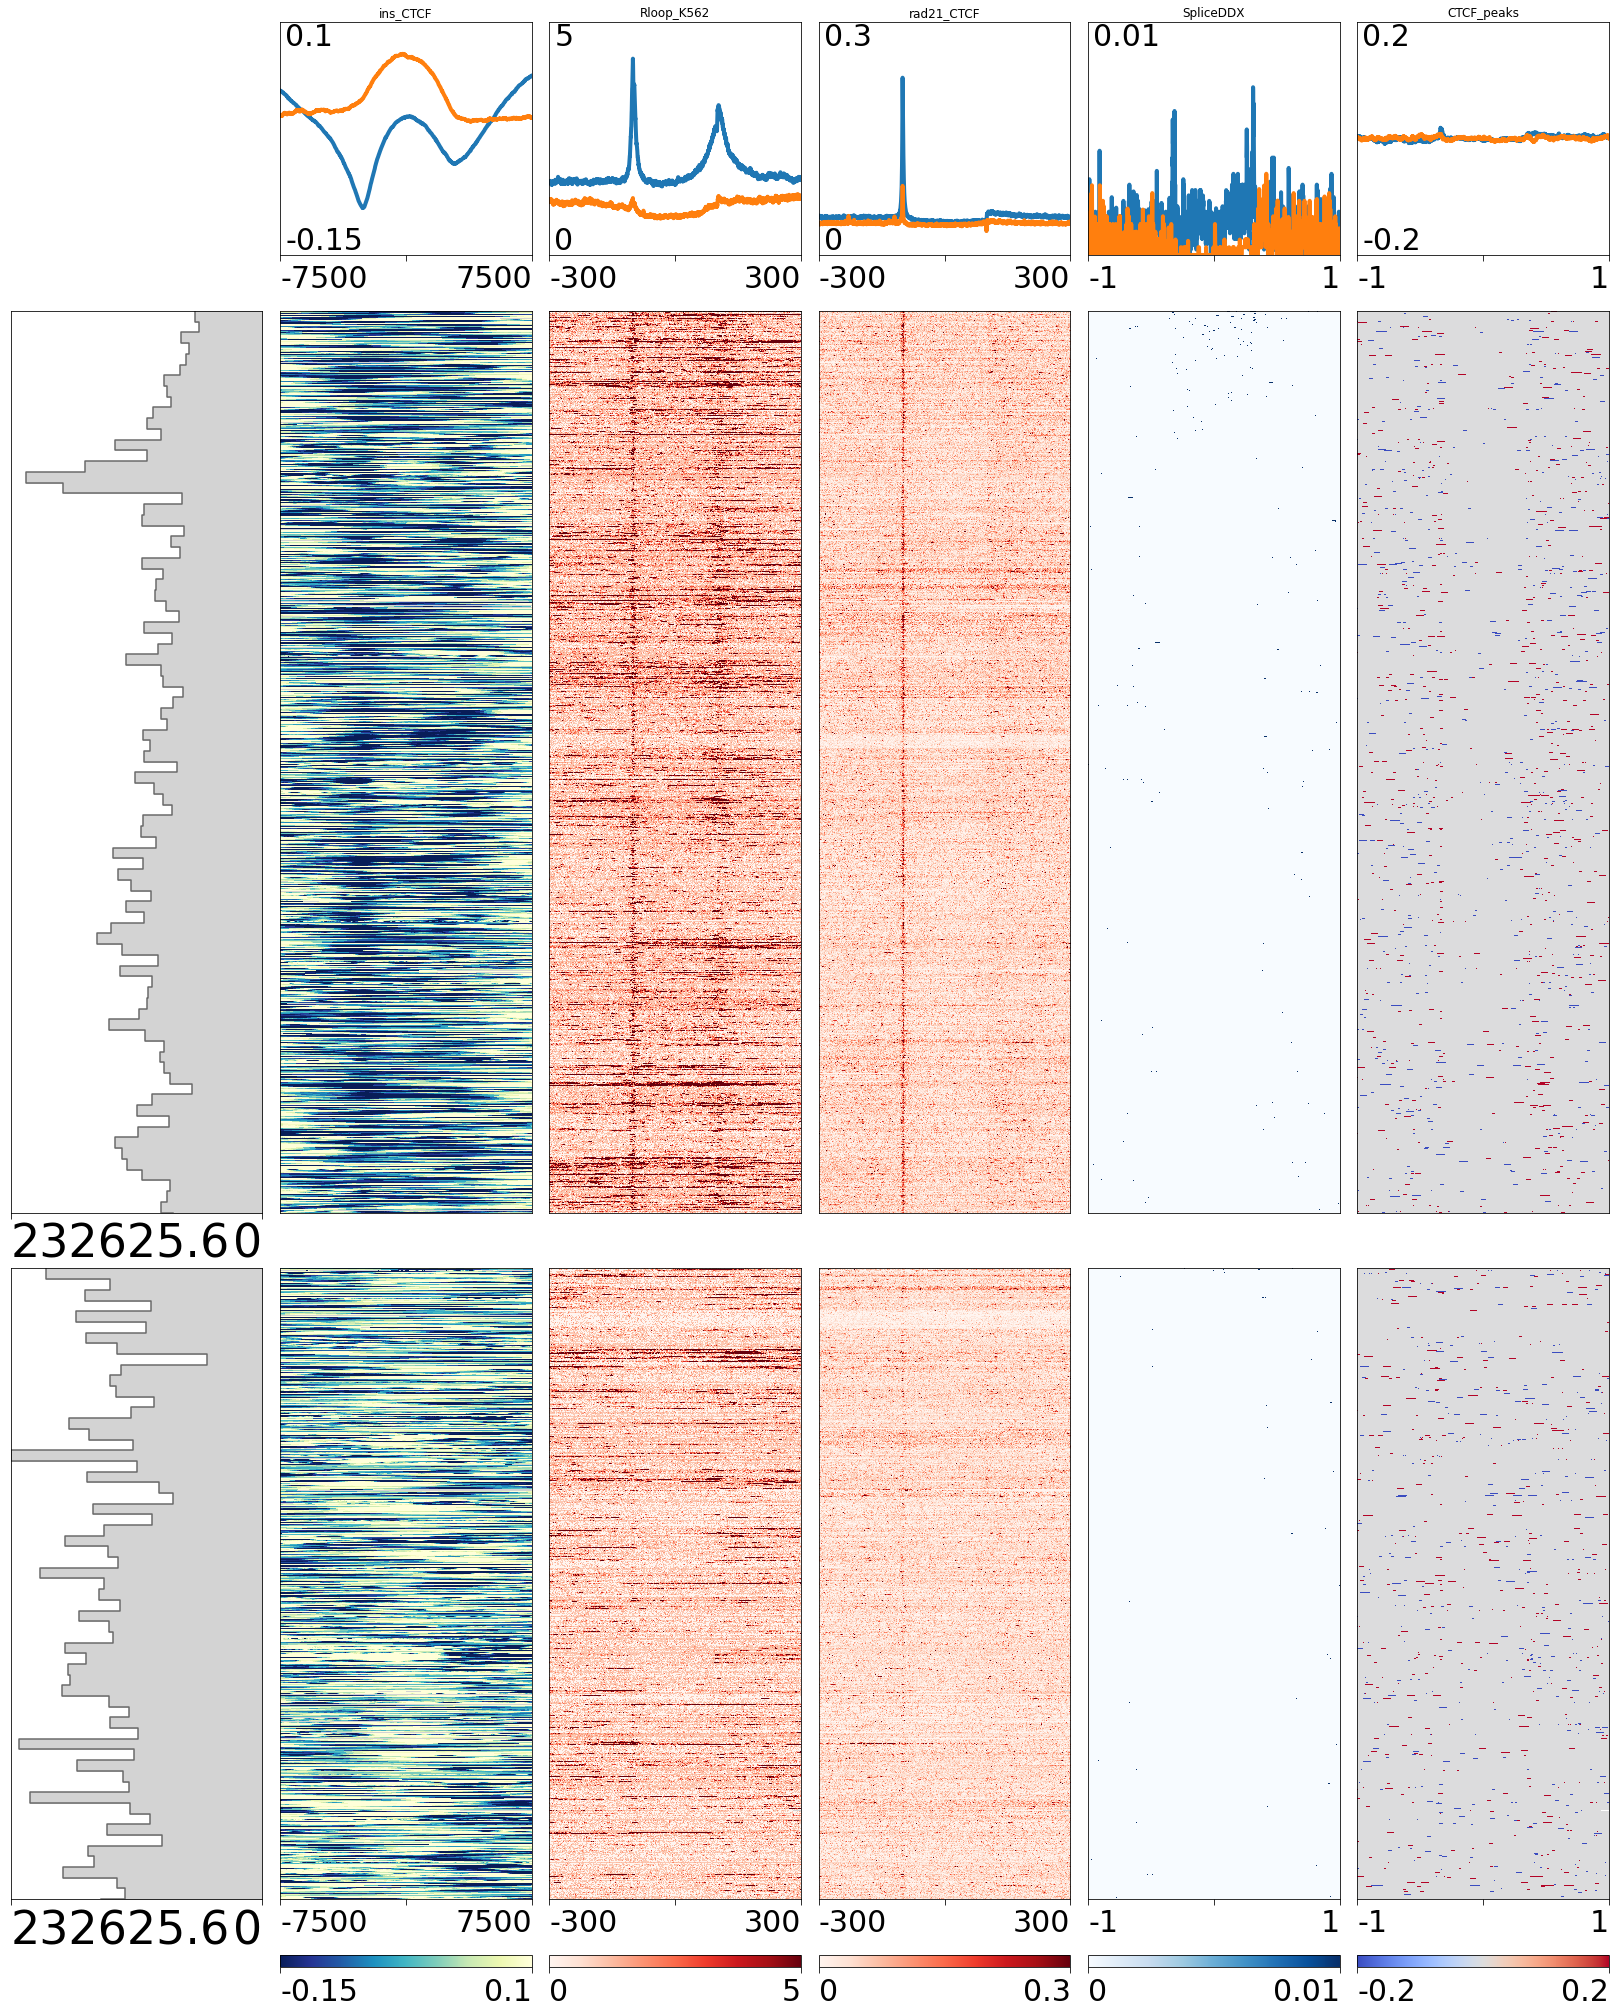

In [30]:
# ordered by the gene size ...
xtra_axs=plot_stackups_sets(
          extra_plots = [0],
          hmss = hmss,
          titles = titles,
          limss = _limss,
          cmps = _cmps,
          norms=_norms,
          binsizes=_binsizes,
#           labels=None,
          fillmissing=False,
          interpolation="nearest",
          inch_per_1k_stack = 3,
          fig_fontsize=30,
         )



# ###############
# # try adding a plpot controlling the size of the gene on the side of the stacups ...
# #
# ################
rolling_win = 50

feature_key = ('high', 'long')
ddd1 = gene_groups.get_group(feature_key).iloc[reordered_jdxs[feature_key]]["size"].reset_index(drop=True).rolling(window=rolling_win).mean().iloc[rolling_win::rolling_win]

feature_key = ('no', 'long')
ddd2 = gene_groups.get_group(feature_key).iloc[reordered_jdxs[feature_key]]["size"].reset_index(drop=True).rolling(window=rolling_win).mean().iloc[rolling_win::rolling_win]

y, color = len(ddd1), "lightgrey"
width_k = ddd1.values

common_width_max = max([np.nanmax(ddd1.values),np.nanmax(ddd2.values) ])#max(np.nanmax(width[k]) for k in width)
col_index = 0 #extra_order[idx]
# for i, feature_key in enumerate(stackup_dict):
i = 0
_y = np.arange(y)
_width = width_k
_color = color
xtra_axs[col_index][i].step(_width,_y,color="dimgray")
xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
xtra_axs[col_index][i].invert_yaxis()
xtra_axs[col_index][i].invert_xaxis()
xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
xtra_axs[col_index][i].set_ylim(max(_y), 0)
xtra_axs[col_index][i].set_xlim(common_width_max,0)
xtra_axs[col_index][i].set_yticks([])
xtra_axs[col_index][i].set_yticklabels([])   
xtra_axs[col_index][i].set_xticks([])
xtra_axs[col_index][i].set_xticklabels([])   
xtra_axs[col_index][i].set_xticks([common_width_max,0])
xtra_axs[col_index][i].set_xticklabels([common_width_max,0],fontsize=46)
for _tidx, tick in enumerate(xtra_axs[col_index][i].xaxis.get_majorticklabels()):
    if _tidx == 0:
        tick.set_horizontalalignment("left")
    elif _tidx == 1:
        tick.set_horizontalalignment("right")
xtra_axs[col_index][i].tick_params(axis="x", length=6)


###########################################################################################


y, color = len(ddd2), "lightgrey"
width_k = ddd2.values

common_width_max = np.nanmax(width_k) #max(np.nanmax(width[k]) for k in width)
col_index = 0 #extra_order[idx]
# for i, feature_key in enumerate(stackup_dict):
i = 1
_y = np.arange(y)
_width = width_k
_color = color
xtra_axs[col_index][i].step(_width,_y,color="dimgray")
xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
xtra_axs[col_index][i].invert_yaxis()
xtra_axs[col_index][i].invert_xaxis()
xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
xtra_axs[col_index][i].set_ylim(max(_y), 0)
xtra_axs[col_index][i].set_xlim(common_width_max,0)
xtra_axs[col_index][i].set_yticks([])
xtra_axs[col_index][i].set_yticklabels([])   
xtra_axs[col_index][i].set_xticks([])
xtra_axs[col_index][i].set_xticklabels([])   
xtra_axs[col_index][i].set_xticks([common_width_max,0])
xtra_axs[col_index][i].set_xticklabels([common_width_max,0],fontsize=46)
for _tidx, tick in enumerate(xtra_axs[col_index][i].xaxis.get_majorticklabels()):
    if _tidx == 0:
        tick.set_horizontalalignment("left")
    elif _tidx == 1:
        tick.set_horizontalalignment("right")
xtra_axs[col_index][i].tick_params(axis="x", length=6)



# # ddd = gene_groups.get_group(('high', 'long')).iloc[reordered_jdxs[("high","long")]]["size"].reset_index(drop=True).rolling(window=100)
# # axs[0][0].barh(ddd.values,ddd.index,marker="o",linewidth=0,alpha=0.1)
# axs[0][0].barh(ddd.index,ddd.values,height=90)
# axs[0][0].invert_xaxis()
# axs[0][0].set_ylim(0+50,1100+50)
# ddd = gene_groups.get_group(('no', 'long')).iloc[reordered_jdxs[("high","long")]]["size"].reset_index(drop=True).rolling(window=100).mean().iloc[::100]
# axs[0][1].barh(ddd.index,ddd.values,height=90)
# axs[0][1].invert_xaxis()
# axs[0][1].set_ylim(0+50,1100+50)

# ax = plt.gca()
# ax.set_yscale("log")
# gene_groups.get_group(('high', 'long')).iloc[reordered_jdxs[("high","long")]]["size"].reset_index(drop=True).rolling(window=100).mean().plot(ax=ax,marker="o",linewidth=0,alpha=0.1,color="red")

# reordered_jdxs[feature_key]
# .groups[('high', 'long')]